In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import matplotlib
import copy

In [2]:
def chw2hwc(chw):
    assert 3 == len(chw.shape)
    if isinstance(chw, torch.Tensor):
        hwc = torch.permute(chw, (1, 2, 0))
    elif isinstance(chw, np.ndarray):
        hwc = np.moveaxis(chw, 0, -1)
    return hwc

In [3]:
def colorize(
    value, 
    vmin=None, 
    vmax=None, 
    cmap='turbo_r', 
    invalid_val=-99, 
    invalid_mask=None, 
    background_color=(128, 128, 128, 255), 
    gamma_corrected=False, 
    value_transform=None, 
    vminp=2, 
    vmaxp=95):
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarry): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
        
    mask = np.logical_not(invalid_mask)

    vmin = np.percentile(value[mask],vminp) if vmin is None else vmin
    vmax = np.percentile(value[mask],vmaxp) if vmax is None else vmax
    
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values
    value[invalid_mask] = np.nan
    cmapper = matplotlib.cm.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img

In [4]:
def highlight_target(depth_colored_hwc, mask, alpha=0.8):
    mask_3channel = cv2.merge([mask, mask, mask])
    fg_color = (200, 200, 200)  # Example gray value in BGR format
    fg_overlay = np.full_like(depth_colored_hwc, fg_color, dtype=np.uint8)
    inverse_mask = cv2.bitwise_not(mask)
    highlighted_image = np.where(mask_3channel == 0,
                                 (1 - alpha) * depth_colored_hwc + alpha * fg_overlay,
                                 depth_colored_hwc).astype(np.uint8)
    
    contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    highlighted_image = cv2.drawContours(highlighted_image, contours, -1, (0, 0, 0), 1)
    return highlighted_image

In [5]:
pix2gestalt_depth_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_baseline/cvpr_base_pix2gestalt_results_update/amodal_aligned_depth' # {}_depth.png
pix2gestalt_matting_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_baseline/cvpr_base_pix2gestalt_results_update/amodal_mask' # {}}_amodal_mask
stitch_depth_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results_pickup/aligned_depth' # {}_depth.png
stitch_raw_depth_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results_pickup/raw_depth' # {}_depth.png
stitch_matting_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results_pickup/matting' # {}_matting.png
rgb_show = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results/combined_image' # {}_combined.png
gt = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results/gt' # {}_gt.png
gt_amodal_mask_path = '/ibex/ai/home/liz0l/codes/depth-fm/data/sam/pix2gestalt_occlusions_release/whole_mask' # {}_whole_mask.png
ours_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_dav2/vitl_results/amodal_depth' # {}_depth.png
save_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/saves'
ours_fm_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_depthfm/depthfm_results/amodal_depth' # {}_depth.png
observation_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_results/observe' # {}_observation.png
visible_mask_path = '/ibex/ai/home/liz0l/codes/depth-fm/data/sam/pix2gestalt_occlusions_release/visible_object_mask'


In [25]:
# id = 10537752 # case 1 NEED 5 CASES xxxxxx
# id = 10072253 # case 2  -- yes
# id = 8535471 # case 3
# id = 6389633
# id = 6333511 # case 4 -- 5931396 yes
id = 1460103 # yes

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

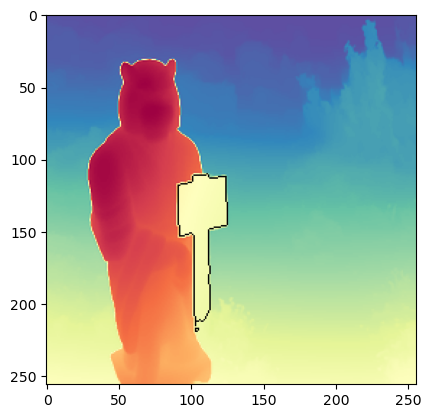

In [26]:
# GT
gt_depth = Image.open(os.path.join(gt, "{}_gt.png".format(id))).resize((256, 256))
gt_depth = np.asarray(gt_depth)
gt_depth = gt_depth / 65535.0
gt_depth_colored = colorize(gt_depth, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
plt.imshow(gt_depth_colored)

gt_amodal_mask = Image.open(os.path.join(gt_amodal_mask_path, "{}_whole_mask.png".format(id)))
gt_amodal_mask = np.asarray(gt_amodal_mask)
gt_amodal_mask = gt_amodal_mask
gt_depth_colored_highlited = highlight_target(gt_depth_colored, gt_amodal_mask, alpha=0.0)
plt.imshow(gt_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_gt.png'.format(id)), gt_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

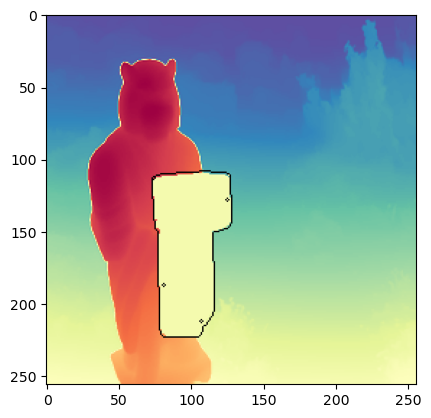

In [27]:
# pix2gestalt
pix2gestalt_amodal_mask = Image.open(os.path.join(pix2gestalt_matting_path, "{}_amodal_mask.png".format(id))).resize((256, 256))
pix2gestalt_amodal_mask = np.asarray(pix2gestalt_amodal_mask)
pix2gestalt_amodal_mask = pix2gestalt_amodal_mask

pix2gestalt_depth = Image.open(os.path.join(pix2gestalt_depth_path, "{}_depth.png".format(id)))
pix2gestalt_depth = np.asarray(pix2gestalt_depth)
pix2gestalt_depth = pix2gestalt_depth / 65535.0
pix2gestalt_depth_bg = copy.deepcopy(gt_depth)
pix2gestalt_depth_bg[pix2gestalt_amodal_mask > 0] = pix2gestalt_depth[pix2gestalt_amodal_mask > 0]
pix2gestalt_depth_agg = copy.deepcopy(pix2gestalt_depth_bg)

pix2gestalt_depth_colored = colorize(pix2gestalt_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
pix2gestalt_depth_colored_highlited = highlight_target(pix2gestalt_depth_colored, pix2gestalt_amodal_mask, alpha=0.0)

plt.imshow(pix2gestalt_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_pix.png'.format(id)), pix2gestalt_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


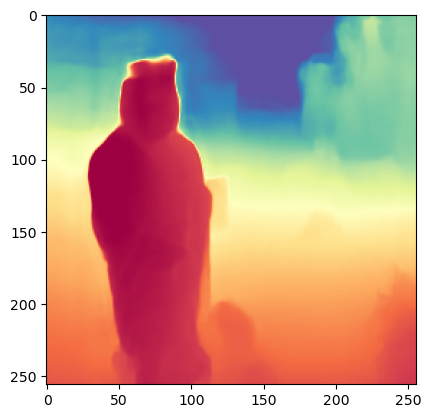

In [28]:
# stitch part1
stitch_amodal_mask = Image.open(os.path.join(stitch_matting_path, "{}_matting.png".format(id))).resize((256, 256))
stitch_amodal_mask = np.asarray(stitch_amodal_mask)
stitch_amodal_mask = stitch_amodal_mask

stitch_depth = Image.open(os.path.join(stitch_depth_path, "{}_depth.png".format(id))).resize((256, 256))
stitch_depth = np.asarray(stitch_depth)

stitch_raw_depth = Image.open(os.path.join(stitch_raw_depth_path, "{}_depth.png".format(id))).resize((256, 256))
stitch_raw_depth = np.asarray(stitch_raw_depth)
stitch_raw_depth_colored = colorize(stitch_raw_depth, cmap='Spectral')[:, :, :3]
plt.imshow(stitch_raw_depth_colored)



/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


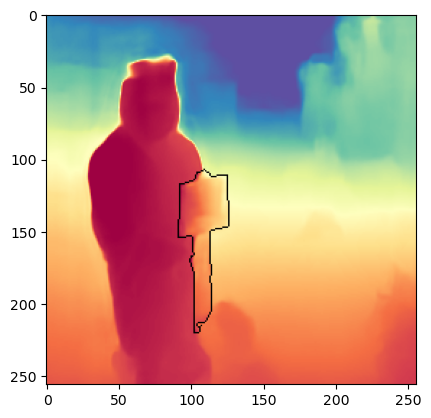

True

In [29]:
# stitch part2
stitch_raw_depth_bg = copy.deepcopy(stitch_raw_depth)
stitch_raw_depth_bg[stitch_amodal_mask > 0] = stitch_depth[stitch_amodal_mask > 0]
stitch_raw_depth_depth_agg = copy.deepcopy(stitch_raw_depth_bg)

stitch_depth_colored = colorize(stitch_raw_depth_depth_agg, cmap='Spectral')[:, :, :3]
stitch_depth_colored_highlited = highlight_target(stitch_depth_colored, stitch_amodal_mask, alpha=0.0)
plt.imshow(stitch_depth_colored_highlited)
plt.show()
cv2.imwrite(os.path.join(save_path, '{}_stitch.png'.format(id)), stitch_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

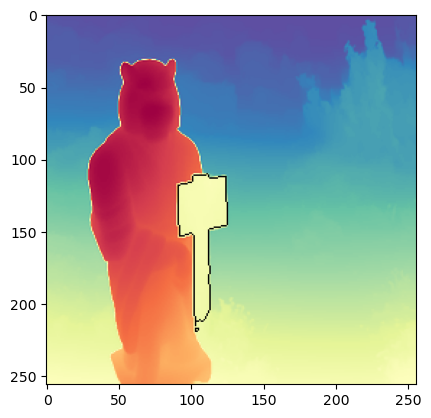

In [30]:
# ours dav2
ours_depth = Image.open(os.path.join(ours_path, "{}_depth.png".format(id))).resize((256, 256))
ours_depth = np.asarray(ours_depth)
ours_depth = ours_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = ours_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_ours.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

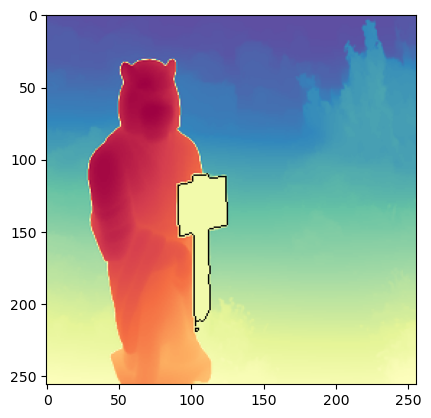

In [31]:
# ours depthfm
ours_depth = Image.open(os.path.join(ours_fm_path, "{}_depth.png".format(id))).resize((256, 256))
ours_depth = np.asarray(ours_depth)
ours_depth = ours_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = ours_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_ours_fm.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])



/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

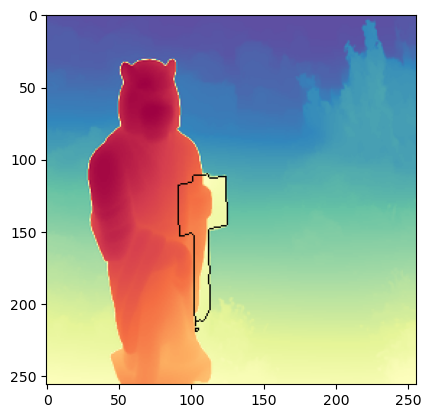

In [32]:
# observation
obs_depth = Image.open(os.path.join(observation_path, "{}_observation.png".format(id))).resize((256, 256))
obs_depth = np.asarray(obs_depth)
obs_depth = obs_depth / 65535.0

obs_depth_colored = colorize(obs_depth, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
obs_depth_colored = highlight_target(obs_depth_colored, gt_amodal_mask, alpha=0.0)

plt.imshow(obs_depth_colored)
cv2.imwrite(os.path.join(save_path, '{}_observation.png'.format(id)), obs_depth_colored[:, :, [2, 1, 0]])

In [33]:
dplab_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_baseline/deeplab/20241024_142321/amodal_depth' # {}_depth.png
jo_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/project_folder/cvpr_baseline/jo/20241024_194215/amodal_depth' # {}_depth.png

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

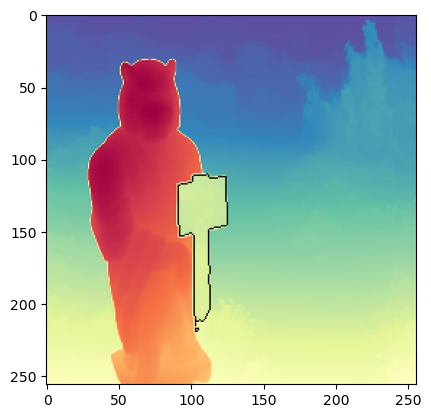

In [34]:
# jo reproduce
jo_depth = Image.open(os.path.join(jo_path, "{}_depth.png".format(id))).resize((256, 256))
jo_depth = np.asarray(jo_depth)
jo_depth = jo_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = jo_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_jo.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])

# ours
jo_depth = Image.open(os.path.join(jo_path, "{}_depth_aligned.png".format(id))).resize((256, 256))
jo_depth = np.asarray(jo_depth)
jo_depth = jo_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = jo_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

# plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_jo_aligned.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


True

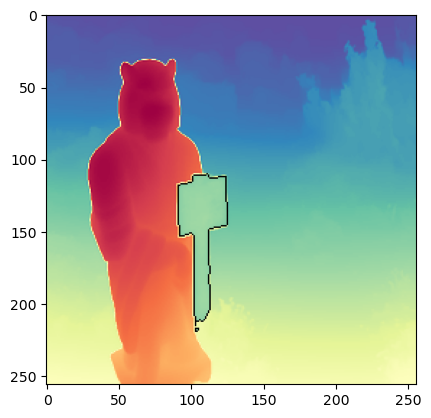

In [35]:
# dplab reproduce
jo_depth = Image.open(os.path.join(dplab_path, "{}_depth.png".format(id))).resize((256, 256))
jo_depth = np.asarray(jo_depth)
jo_depth = jo_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = jo_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_dplab.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])

# ours
jo_depth = Image.open(os.path.join(dplab_path, "{}_depth_aligned.png".format(id))).resize((256, 256))
jo_depth = np.asarray(jo_depth)
jo_depth = jo_depth / 65535.0
ours_depth_bg = copy.deepcopy(gt_depth)
ours_depth_bg[gt_amodal_mask > 0] = jo_depth[gt_amodal_mask > 0]
ours_depth_agg = copy.deepcopy(ours_depth_bg)

ours_depth_colored = colorize(ours_depth_agg, vmin=0, vmax=1, cmap='Spectral_r')[:, :, :3]
ours_depth_colored_highlited = highlight_target(ours_depth_colored, gt_amodal_mask, alpha=0.0)

# plt.imshow(ours_depth_colored_highlited)
cv2.imwrite(os.path.join(save_path, '{}_dplab_aligned.png'.format(id)), ours_depth_colored_highlited[:, :, [2, 1, 0]])

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


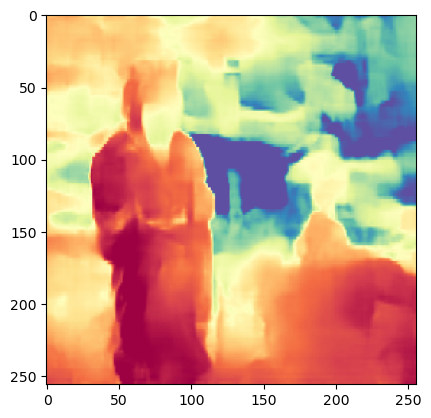

In [36]:

jo_amodal_path = '/ibex/ai/home/liz0l/codes/Occlusion-aware-Amodal-Depth-Estimation-for-Enhancing-3D-Reconstruction-from-a-Single-Image/work_dir/results/amodal_depth' # {}_depth.png
jo_raw_path = '/ibex/ai/home/liz0l/codes/Occlusion-aware-Amodal-Depth-Estimation-for-Enhancing-3D-Reconstruction-from-a-Single-Image/work_dir/results/raw_depth'

jo_depth = Image.open(os.path.join(jo_amodal_path, "{}_depth.png".format(id))).resize((256, 256))
jo_depth = np.asarray(jo_depth)

jo_raw_depth = Image.open(os.path.join(jo_raw_path, "{}_depth.png".format(id))).resize((256, 256))
jo_raw_depth = np.asarray(jo_raw_depth)
jo_raw_depth_colored = colorize(jo_raw_depth, cmap='Spectral')[:, :, :3]
plt.imshow(jo_raw_depth_colored)



/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


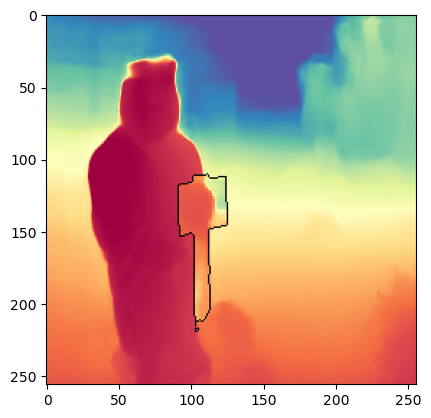

True

In [41]:
jo_raw_depth_bg = copy.deepcopy(stitch_raw_depth)
# jo_raw_depth_bg = copy.deepcopy(jo_raw_depth)

jo_raw_depth_bg[gt_amodal_mask > 0] = jo_depth[gt_amodal_mask > 0]
jo_raw_depth_agg = copy.deepcopy(jo_raw_depth_bg)

jo_depth_colored = colorize(jo_raw_depth_agg, cmap='Spectral')[:, :, :3]
jo_depth_colored_highlited = highlight_target(jo_depth_colored, gt_amodal_mask, alpha=0.0)
plt.imshow(jo_depth_colored_highlited)
plt.show()
cv2.imwrite(os.path.join(save_path, '{}_jo_official.png'.format(id)), jo_depth_colored_highlited[:, :, [2, 1, 0]])


In [38]:

def align_depth_least_square(
    gt_arr: np.ndarray,
    pred_arr: np.ndarray,
    valid_mask_arr: np.ndarray,
    return_scale_shift=True,
    max_resolution=None,
):
    ori_shape = pred_arr.shape  # input shape

    gt = gt_arr.squeeze()  # [H, W]
    pred = pred_arr.squeeze()
    valid_mask = valid_mask_arr.squeeze()

    # Downsample
    if max_resolution is not None:
        scale_factor = np.min(max_resolution / np.array(ori_shape[-2:]))
        if scale_factor < 1:
            downscaler = torch.nn.Upsample(scale_factor=scale_factor, mode="nearest")
            gt = downscaler(torch.as_tensor(gt).unsqueeze(0)).numpy()
            pred = downscaler(torch.as_tensor(pred).unsqueeze(0)).numpy()
            valid_mask = (
                downscaler(torch.as_tensor(valid_mask).unsqueeze(0).float())
                .bool()
                .numpy()
            )

    assert (
        gt.shape == pred.shape == valid_mask.shape
    ), f"{gt.shape}, {pred.shape}, {valid_mask.shape}"

    gt_masked = gt[valid_mask].reshape((-1, 1))
    pred_masked = pred[valid_mask].reshape((-1, 1))

    # numpy solver
    _ones = np.ones_like(pred_masked)
    A = np.concatenate([pred_masked, _ones], axis=-1)
    X = np.linalg.lstsq(A, gt_masked, rcond=None)[0]
    scale, shift = X

    aligned_pred = pred_arr * scale + shift

    # restore dimensions
    aligned_pred = aligned_pred.reshape(ori_shape)

    if return_scale_shift:
        return aligned_pred, scale, shift
    else:
        return aligned_pred
    

In [39]:

visible_mask = Image.open(os.path.join(visible_mask_path, "{}_visible_mask.png".format(id)))
visible_mask = np.asarray(visible_mask)
visible_mask = visible_mask

/tmp/ipykernel_383426/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


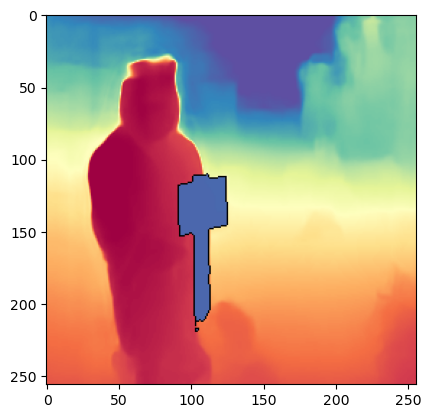

True

In [40]:


depth_align, scale, shift = align_depth_least_square(
    stitch_raw_depth,
    jo_depth,
    visible_mask,
    return_scale_shift=True,
    max_resolution=None,)
    
jo_raw_depth_bg = copy.deepcopy(stitch_raw_depth)
# jo_raw_depth_bg = copy.deepcopy(jo_raw_depth)

jo_raw_depth_bg[gt_amodal_mask > 0] = depth_align[gt_amodal_mask > 0]
jo_raw_depth_agg = copy.deepcopy(jo_raw_depth_bg)

jo_depth_colored = colorize(jo_raw_depth_agg, cmap='Spectral')[:, :, :3]
jo_depth_colored_highlited = highlight_target(jo_depth_colored, gt_amodal_mask, alpha=0.0)
plt.imshow(jo_depth_colored_highlited)
plt.show()
# cv2.imwrite(os.path.join(save_path, '{}_jo_official.png'.format(id)), jo_depth_colored_highlited[:, :, [2, 1, 0]])

